In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx

import os
from pathlib import Path
import pykrige as pk

In [3]:
data_path = Path(os.environ["DATA_PATH"])

In [42]:
df = gpd.GeoDataFrame(
    pd.read_excel(data_path / "datos" / "calidad_del_aire.xlsx", sheet_name=1)
    .assign(
        geometry=lambda df: gpd.points_from_xy(df["lng"], df["lat"]),
        date=lambda df: pd.to_datetime(df["Año"].astype(str) + "-" + df["Mes"].astype(str) + "-01", format="%Y-%m-%d"),
    )
    .rename(columns={"µg/m³": "mug/m3"})
    .drop(columns=["lng", "lat", "Año", "Mes"]),
    crs="EPSG:4326",
    geometry="geometry"
).to_crs("EPSG:6372")

In [83]:
temp

,idmonitor,mug/m3,color,desc,geometry,date
233,A0006,51,#ff8484,Arriba del límite,POINT (1225824.508 2344045.8),2020-01-01
234,A0013,36,#ff8484,Arriba del límite,POINT (1227417.467 2348321.429),2020-01-01
235,EMMCA,37,#ff8484,Arriba del límite,POINT (1228114.255 2345842.931),2020-01-01
236,M0003,57,#ff8484,Arriba del límite,POINT (1220802.123 2345535.155),2020-01-01
237,M0011,24,#00e400,Abajo del límite,POINT (1235273.402 2348581.72),2020-01-01
...,...,...,...,...,...,...
525,pa18809,40,#ff8484,Arriba del límite,POINT (1231551.313 2344170.449),2020-12-01
526,pa18855,45,#ff8484,Arriba del límite,POINT (1238151.164 2339945.974),2020-12-01
527,pa21885,36,#ff8484,Arriba del límite,POINT (1233911.436 2347510.876),2020-12-01
528,pa25179,35,#ff8484,Arriba del límite,POINT (1236385.734 2344297.078),2020-12-01


In [85]:
year = 2020
temp = (
    df
    .query(f"'{year - 1}-12-31' < date < '{year + 1}-01-01'")
    .groupby("idmonitor")
    .agg({
        "geometry": "first",
        "mug/m3": "mean"
    })
)

xmin, ymin, xmax, ymax = temp.total_bounds
xrange = np.arange(xmin, xmax, 100)
yrange = np.arange(ymin, ymax, 100)

model = pk.uk.UniversalKriging(
    temp["geometry"].x,
    temp["geometry"].y,
    temp["mug/m3"],
    variogram_model="linear",
)

z, ss = model.execute("grid", xrange, yrange)

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column to use has not been set. 
There are columns with geometry data type (['geometry']), and you can either set one as the active geometry with df.set_geometry("name") or access the column as a GeoSeries (df["name"]) and call the method directly on it.

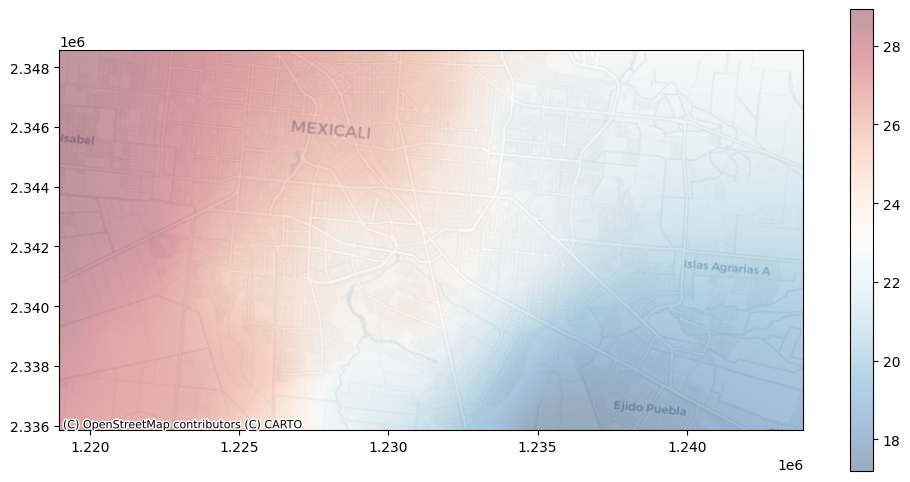

In [82]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(z, alpha=0.8, extent=(xmin, xmax, ymin, ymax))
cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)
g = ax.imshow(z, alpha=0.4, extent=(xmin, xmax, ymin, ymax), cmap="RdBu_r")
fig.colorbar(g)